# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](http://yann.lecun.com/exdb/mnist/) and include:

88% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
95.3% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)

MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Installation

In [1]:
# Update the PATH to include the user installation directory. 
import os
os.environ['PATH'] = f"{os.environ['PATH']}:/root/.local/bin"

# Restart the Kernel before you move on to the next step.

#### Important: Restart the Kernel before you move on to the next step.

In [2]:
# Install requirements
!python -m pip install -r requirements.txt

  Using cached opencv_python_headless-4.5.3.56-cp38-cp38-manylinux2014_x86_64.whl (37.1 MB)
  Using cached matplotlib-3.4.3-cp38-cp38-manylinux1_x86_64.whl (10.3 MB)
  Using cached numpy-1.21.2-cp38-cp38-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (15.8 MB)
  Using cached Pillow-7.0.0-cp38-cp38-manylinux1_x86_64.whl (2.1 MB)
  Using cached bokeh-2.1.1-py3-none-any.whl
  Using cached torch-1.11.0-cp38-cp38-manylinux1_x86_64.whl (750.6 MB)
  Using cached torchvision-0.12.0-cp38-cp38-manylinux1_x86_64.whl (21.0 MB)
  Using cached tqdm-4.63.0-py2.py3-none-any.whl (76 kB)
  Using cached ipywidgets-7.7.0-py2.py3-none-any.whl (123 kB)
  Using cached livelossplot-0.5.4-py3-none-any.whl (22 kB)
  Using cached pytest-7.1.1-py3-none-any.whl (297 kB)
  Using cached pandas-1.3.5-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.5 MB)
  Using cached seaborn-0.11.2-py3-none-any.whl (292 kB)
  Using cached jupyter-1.0.0-py2.py3-none-any.whl (2.7 kB)
  Using cached ipykernel-4.10.0-py3-no

## Imports

In [3]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [4]:
from torch.utils.data import DataLoader

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [5]:
# Define transforms
transform = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize((0.5,), (0.5,))
])

# Create training set and define training dataloader
training_data = torchvision.datasets.MNIST(root="data", train=True, download=True, transform=transform)
testing_data = torchvision.datasets.MNIST(root="data", train=False, download=True, transform=transform)

# Create test set and define test dataloader
train_loader = DataLoader(training_data, batch_size=64)
test_loader = DataLoader(testing_data, batch_size=64)

## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?

**DOUBLE CLICK THIS CELL TO MODIFY**

- I used `RandomHorizontalFlip` in order to augment the training data and improve the model's ability to generalize when training
- I also used `Normalize` to scale the pixels of each image being used as input to our network

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [6]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))
    
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

In [7]:
# Explore data
# Get length of training and test dataset
print(f"Training dataset: {len(training_data)}")
print(f"Testing dataset: {len(testing_data)}")

#Get number of classes from the data
print(training_data.classes)
print(f"Number of classes: {len(training_data.classes)}")

Training dataset: 60000
Testing dataset: 10000
['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']
Number of classes: 10


In [8]:
samples = next(iter(train_loader))

# Identify shape of image tensors in trainloader
for labels, images in enumerate(samples):
    print(images.shape)
    

torch.Size([64, 1, 28, 28])
torch.Size([64])


5


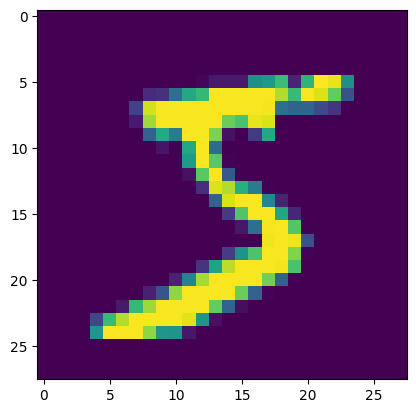

0


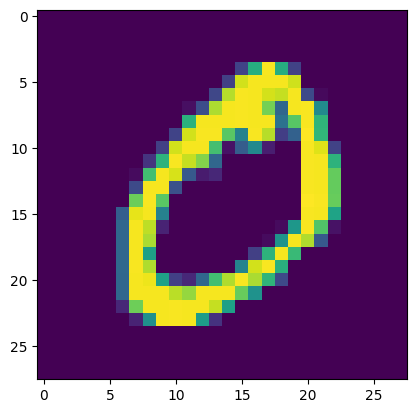

4


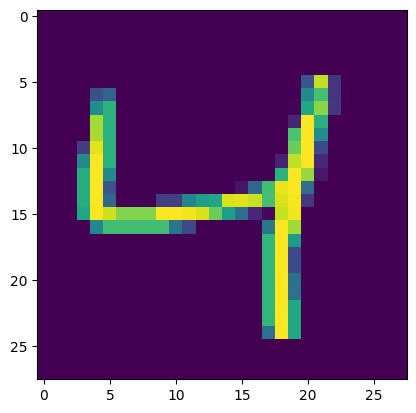

1


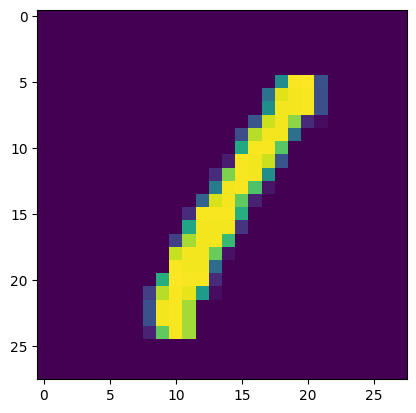

9


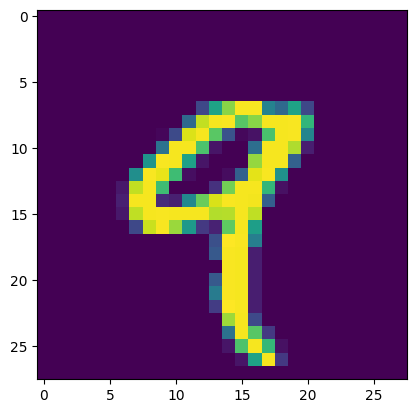

In [9]:
# Display some images from the train_loader
show5(train_loader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [10]:
# Build image classifier neural net
class ImageClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.activation = F.relu
        self.layer1 = nn.Linear(28 * 28, 128)
        self.layer2 = nn.Linear(128, 64)
        self.layer3 = nn.Linear(64, 10)
        
    def forward(self, x):
        # x = self.dropout(x)
        x = torch.flatten(x, 1) 
        x = self.activation(self.layer1(x))
        # x = self.dropout(x)
        x = self.activation(self.layer2(x))
        # x = self.dropout(x)
        x = self.layer3(x)
        
        return x

In [11]:
# Set device to gpu if available else cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [12]:
# Instantiate the model 
model = ImageClassifier()

#Send model to gpu 
model.to(device)

ImageClassifier(
  (layer1): Linear(in_features=784, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=64, bias=True)
  (layer3): Linear(in_features=64, out_features=10, bias=True)
)

In [13]:
# Define optimizer to be used
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9)

#Define loss function to be used
# criterion = nn.NLLLoss()
criterion = nn.CrossEntropyLoss()

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [14]:
epochs =20

train_loss_vals = []
validation_loss_vals = []

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0
    
    for images, labels in train_loader:
        # Send to gpu if available
        images, labels = images.to(device), labels.to(device)
        
        # Reset the gradient
        optimizer.zero_grad()
        
        # Get outputs
        outputs = model(images)
        # logsoft = nn.Softmax(dim=1)
        # Compute the error
        loss = criterion(outputs, labels)
        
        # Backpropagate the error and perform gradient descent
        loss.backward()
        optimizer.step()
        
        # Compute train loss 
        _, preds = torch.max(outputs.data, 1)
        train_correct += (preds == labels).sum().item()
        train_loss += loss.item()
        
    print(f'Epoch: {epoch + 1} Training accuracy: {train_correct / train_loader.dataset.data.shape[0] * 100:.2f}% Training loss: {train_loss/len(train_loader):.5f}')
    train_loss_vals.append(train_loss/len(train_loader))
    
    validation_loss = 0.0
    validation_correct = 0
    
    #Set model to eval mode
    model.eval()
    
    # Run validation loop
    for images, labels in test_loader:
        # Send to gpu
        images, labels = images.to(device), labels.to(device)
        
        # Get outputs from feedforward
        outputs = model(images)
        
        # Compute error
        # logsoft = nn.LogSoftmax(dim=1)
        loss = criterion(outputs, labels)
        
        # Compute validation loss
        _, preds = torch.max(outputs.data, 1)
        validation_correct += (preds == labels).sum().item()
        validation_loss += loss.item()
        
    print(f'Epoch: {epoch + 1} Validation accuracy: {validation_correct / test_loader.dataset.data.shape[0] * 100:.2f}% Validation loss: {validation_loss/len(test_loader):.5f}')
    print("================================================================================================")
    validation_loss_vals.append(validation_loss/len(test_loader))

Epoch: 1 Training accuracy: 84.14% Training loss: 0.54375
Epoch: 1 Validation accuracy: 91.23% Validation loss: 0.27910
Epoch: 2 Training accuracy: 92.86% Training loss: 0.23946
Epoch: 2 Validation accuracy: 92.93% Validation loss: 0.21678
Epoch: 3 Training accuracy: 94.72% Training loss: 0.17690
Epoch: 3 Validation accuracy: 94.56% Validation loss: 0.16684
Epoch: 4 Training accuracy: 95.78% Training loss: 0.14089
Epoch: 4 Validation accuracy: 95.73% Validation loss: 0.13762
Epoch: 5 Training accuracy: 96.50% Training loss: 0.11756
Epoch: 5 Validation accuracy: 96.31% Validation loss: 0.12221
Epoch: 6 Training accuracy: 97.02% Training loss: 0.10050
Epoch: 6 Validation accuracy: 96.77% Validation loss: 0.11070
Epoch: 7 Training accuracy: 97.41% Training loss: 0.08735
Epoch: 7 Validation accuracy: 96.95% Validation loss: 0.10140
Epoch: 8 Training accuracy: 97.75% Training loss: 0.07652
Epoch: 8 Validation accuracy: 97.06% Validation loss: 0.09706
Epoch: 9 Training accuracy: 97.97% Train

Plot the training loss (and validation loss/accuracy, if recorded).

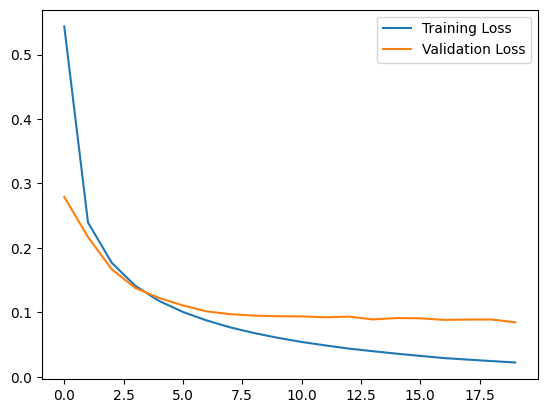

In [15]:
%matplotlib inline

plt.plot(train_loss_vals, label="Training Loss")
plt.plot(validation_loss_vals, label="Validation Loss")
plt.legend()
plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [21]:
with torch.no_grad():
    test_loss = 0.0
    test_correct = 0
    
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
    
        # Compute validation loss
        _, preds = torch.max(outputs.data, 1)
        test_correct += (preds == labels).sum().item()
        test_loss += loss.item()
    print(f'Test accuracy: {test_correct / test_loader.dataset.data.shape[0] * 100:.2f}% Test loss: {test_loss/len(test_loader):.5f}')

Test accuracy: 97.55% Test loss: 0.08449


## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

In [22]:
# Change the learning rate and the optimizer as well
optimizer = optim.Adam(model.parameters(), lr=0.0003)

#  Run training again
epochs =10

train_loss_vals = []
validation_loss_vals = []

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0
    
    for images, labels in train_loader:
        # Send to gpu if available
        images, labels = images.to(device), labels.to(device)
        
        # Reset the gradient
        optimizer.zero_grad()
        
        # Get outputs
        outputs = model(images)
        # logsoft = nn.Softmax(dim=1)
        # Compute the error
        loss = criterion(outputs, labels)
        
        # Backpropagate the error and perform gradient descent
        loss.backward()
        optimizer.step()
        
        # Compute train loss 
        _, preds = torch.max(outputs.data, 1)
        train_correct += (preds == labels).sum().item()
        train_loss += loss.item()
        
    print(f'Epoch: {epoch + 1} Training accuracy: {train_correct / train_loader.dataset.data.shape[0] * 100:.2f}% Training loss: {train_loss/len(train_loader):.5f}')
    train_loss_vals.append(train_loss/len(train_loader))
    
    validation_loss = 0.0
    validation_correct = 0
    
    #Set model to eval mode
    model.eval()
    
    # Run validation loop
    for images, labels in test_loader:
        # Send to gpu
        images, labels = images.to(device), labels.to(device)
        
        # Get outputs from feedforward
        outputs = model(images)
        
        # Compute error
        # logsoft = nn.LogSoftmax(dim=1)
        loss = criterion(outputs, labels)
        
        # Compute validation loss
        _, preds = torch.max(outputs.data, 1)
        validation_correct += (preds == labels).sum().item()
        validation_loss += loss.item()
        
    print(f'Epoch: {epoch + 1} Validation accuracy: {validation_correct / test_loader.dataset.data.shape[0] * 100:.2f}% Validation loss: {validation_loss/len(test_loader):.5f}')
    print("================================================================================================")
    validation_loss_vals.append(validation_loss/len(test_loader))

Epoch: 1 Training accuracy: 99.07% Training loss: 0.02918
Epoch: 1 Validation accuracy: 97.21% Validation loss: 0.10398
Epoch: 2 Training accuracy: 99.20% Training loss: 0.02490
Epoch: 2 Validation accuracy: 97.43% Validation loss: 0.09378
Epoch: 3 Training accuracy: 99.28% Training loss: 0.02232
Epoch: 3 Validation accuracy: 97.43% Validation loss: 0.09347
Epoch: 4 Training accuracy: 99.35% Training loss: 0.02094
Epoch: 4 Validation accuracy: 97.39% Validation loss: 0.09963
Epoch: 5 Training accuracy: 99.33% Training loss: 0.02130
Epoch: 5 Validation accuracy: 97.29% Validation loss: 0.10378
Epoch: 6 Training accuracy: 99.38% Training loss: 0.01935
Epoch: 6 Validation accuracy: 97.49% Validation loss: 0.09727
Epoch: 7 Training accuracy: 99.50% Training loss: 0.01689
Epoch: 7 Validation accuracy: 97.16% Validation loss: 0.11198
Epoch: 8 Training accuracy: 99.44% Training loss: 0.01784
Epoch: 8 Validation accuracy: 97.51% Validation loss: 0.10260
Epoch: 9 Training accuracy: 99.51% Train

In [23]:
# Test the optimized model on the test set again
with torch.no_grad():
    test_loss = 0.0
    test_correct = 0
    
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
    
        # Compute validation loss
        _, preds = torch.max(outputs.data, 1)
        test_correct += (preds == labels).sum().item()
        test_loss += loss.item()
    print(f'Test accuracy: {test_correct / test_loader.dataset.data.shape[0] * 100:.2f}% Test loss: {test_loss/len(test_loader):.5f}')

Test accuracy: 97.66% Test loss: 0.10519


## Saving your model
Using `torch.save`, save your model for future loading.

In [24]:
torch.save(model, './digits_classifier.pt')